<a href="https://colab.research.google.com/github/semthedev/ml-course-2025/blob/main/seminars/22_gp_vol2_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes II

In [ ]:
!pip install jupyter_black

In [ ]:
%load_ext jupyter_black

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid
from scipy.linalg import cholesky, solve_triangular

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF


from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 600
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["figure.figsize"] = (12, 6)

## GP for regression


### How to find a the kernel parameters?

In [ ]:
def kernel(a, b, theta):
    sq_dist = (a**2).sum(1).reshape(-1, 1) + (b**2).sum(1) - 2 * a @ b.T
    return theta[1] * np.exp(-0.5 * theta[0] * sq_dist)

In [ ]:
# points sampled from sin
np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 10)[:, None]
y = np.sin(X) + 0.1 * np.random.randn(*X.shape)
X_test = np.linspace(0, 2 * np.pi, 100)[:, None]

In [ ]:
def neg_log_likelihood(params, X, y):
    theta = params[:2]
    noise = params[2]
    K = kernel(X, X, theta) + noise**2 * np.eye(len(X))
    try:
        L = cholesky(K, lower=True)
    except np.linalg.LinAlgError:
        return np.inf
    # we had:
    # n_log_likelihood = -sp.stats.multivariate_normal(
    #    mu, Sigma, allow_singular=False
    # ).logpdf(y)

    alpha = solve_triangular(L.T, solve_triangular(L, y, lower=True))
    return (
        0.5 * y.T @ alpha
        + np.sum(np.log(np.diag(L)))
        + 0.5 * len(X) * np.log(2 * np.pi)
    )

In [ ]:
initial_params = [30.0, 50.0, 0.1]  # [theta0, theta1, noise]
result = minimize(
    neg_log_likelihood,
    initial_params,
    args=(X, y),
    bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
    method="L-BFGS-B",
)
theta_opt = result.x[:2]
noise_opt = result.x[2]
theta_opt, initial_params[:2],

(array([0.7656668 , 0.52817086]), [30.0, 50.0])

In [ ]:
neg_log_likelihood(initial_params, X, y), neg_log_likelihood(result.x, X, y)

(array([[28.79620678]]), array([[0.3707672]]))

In [ ]:
noise_opt, initial_params[2]

(np.float64(0.0068253348192648), 0.1)

In [ ]:
def gp_predict(X_train, y_train, X_test, theta, noise):
    K = kernel(X_train, X_train, theta) + noise**2 * np.eye(len(X_train))
    K_star = kernel(X_train, X_test, theta)
    K_starstar = kernel(X_test, X_test, theta)

    L = cholesky(K, lower=True)
    # we had:
    # mu = K_star.T @ np.linalg.inv(K + 1e-6 * np.eye(N, N)) @ y
    alpha = solve_triangular(L.T, solve_triangular(L, y_train, lower=True))
    mu = K_star.T @ alpha

    # we had:
    # K_predict = K_star2 - K_star.T @ np.linalg.inv(K + 1e-6 * np.eye(N, N)) @ K_star
    # s2 = np.diag(K_predict)
    v = solve_triangular(L, K_star, lower=True)
    cov = K_starstar - v.T @ v
    return mu, cov

In [ ]:
# Unfitted (initial parameters)
mu_initial, cov_initial = gp_predict(
    X, y, X_test, initial_params[:2], initial_params[2]
)
std_initial = np.sqrt(np.diag(cov_initial))

In [ ]:
# Fitted (optimized parameters)
mu_opt, cov_opt = gp_predict(X, y, X_test, theta_opt, noise_opt)
std_opt = np.sqrt(np.diag(cov_opt))

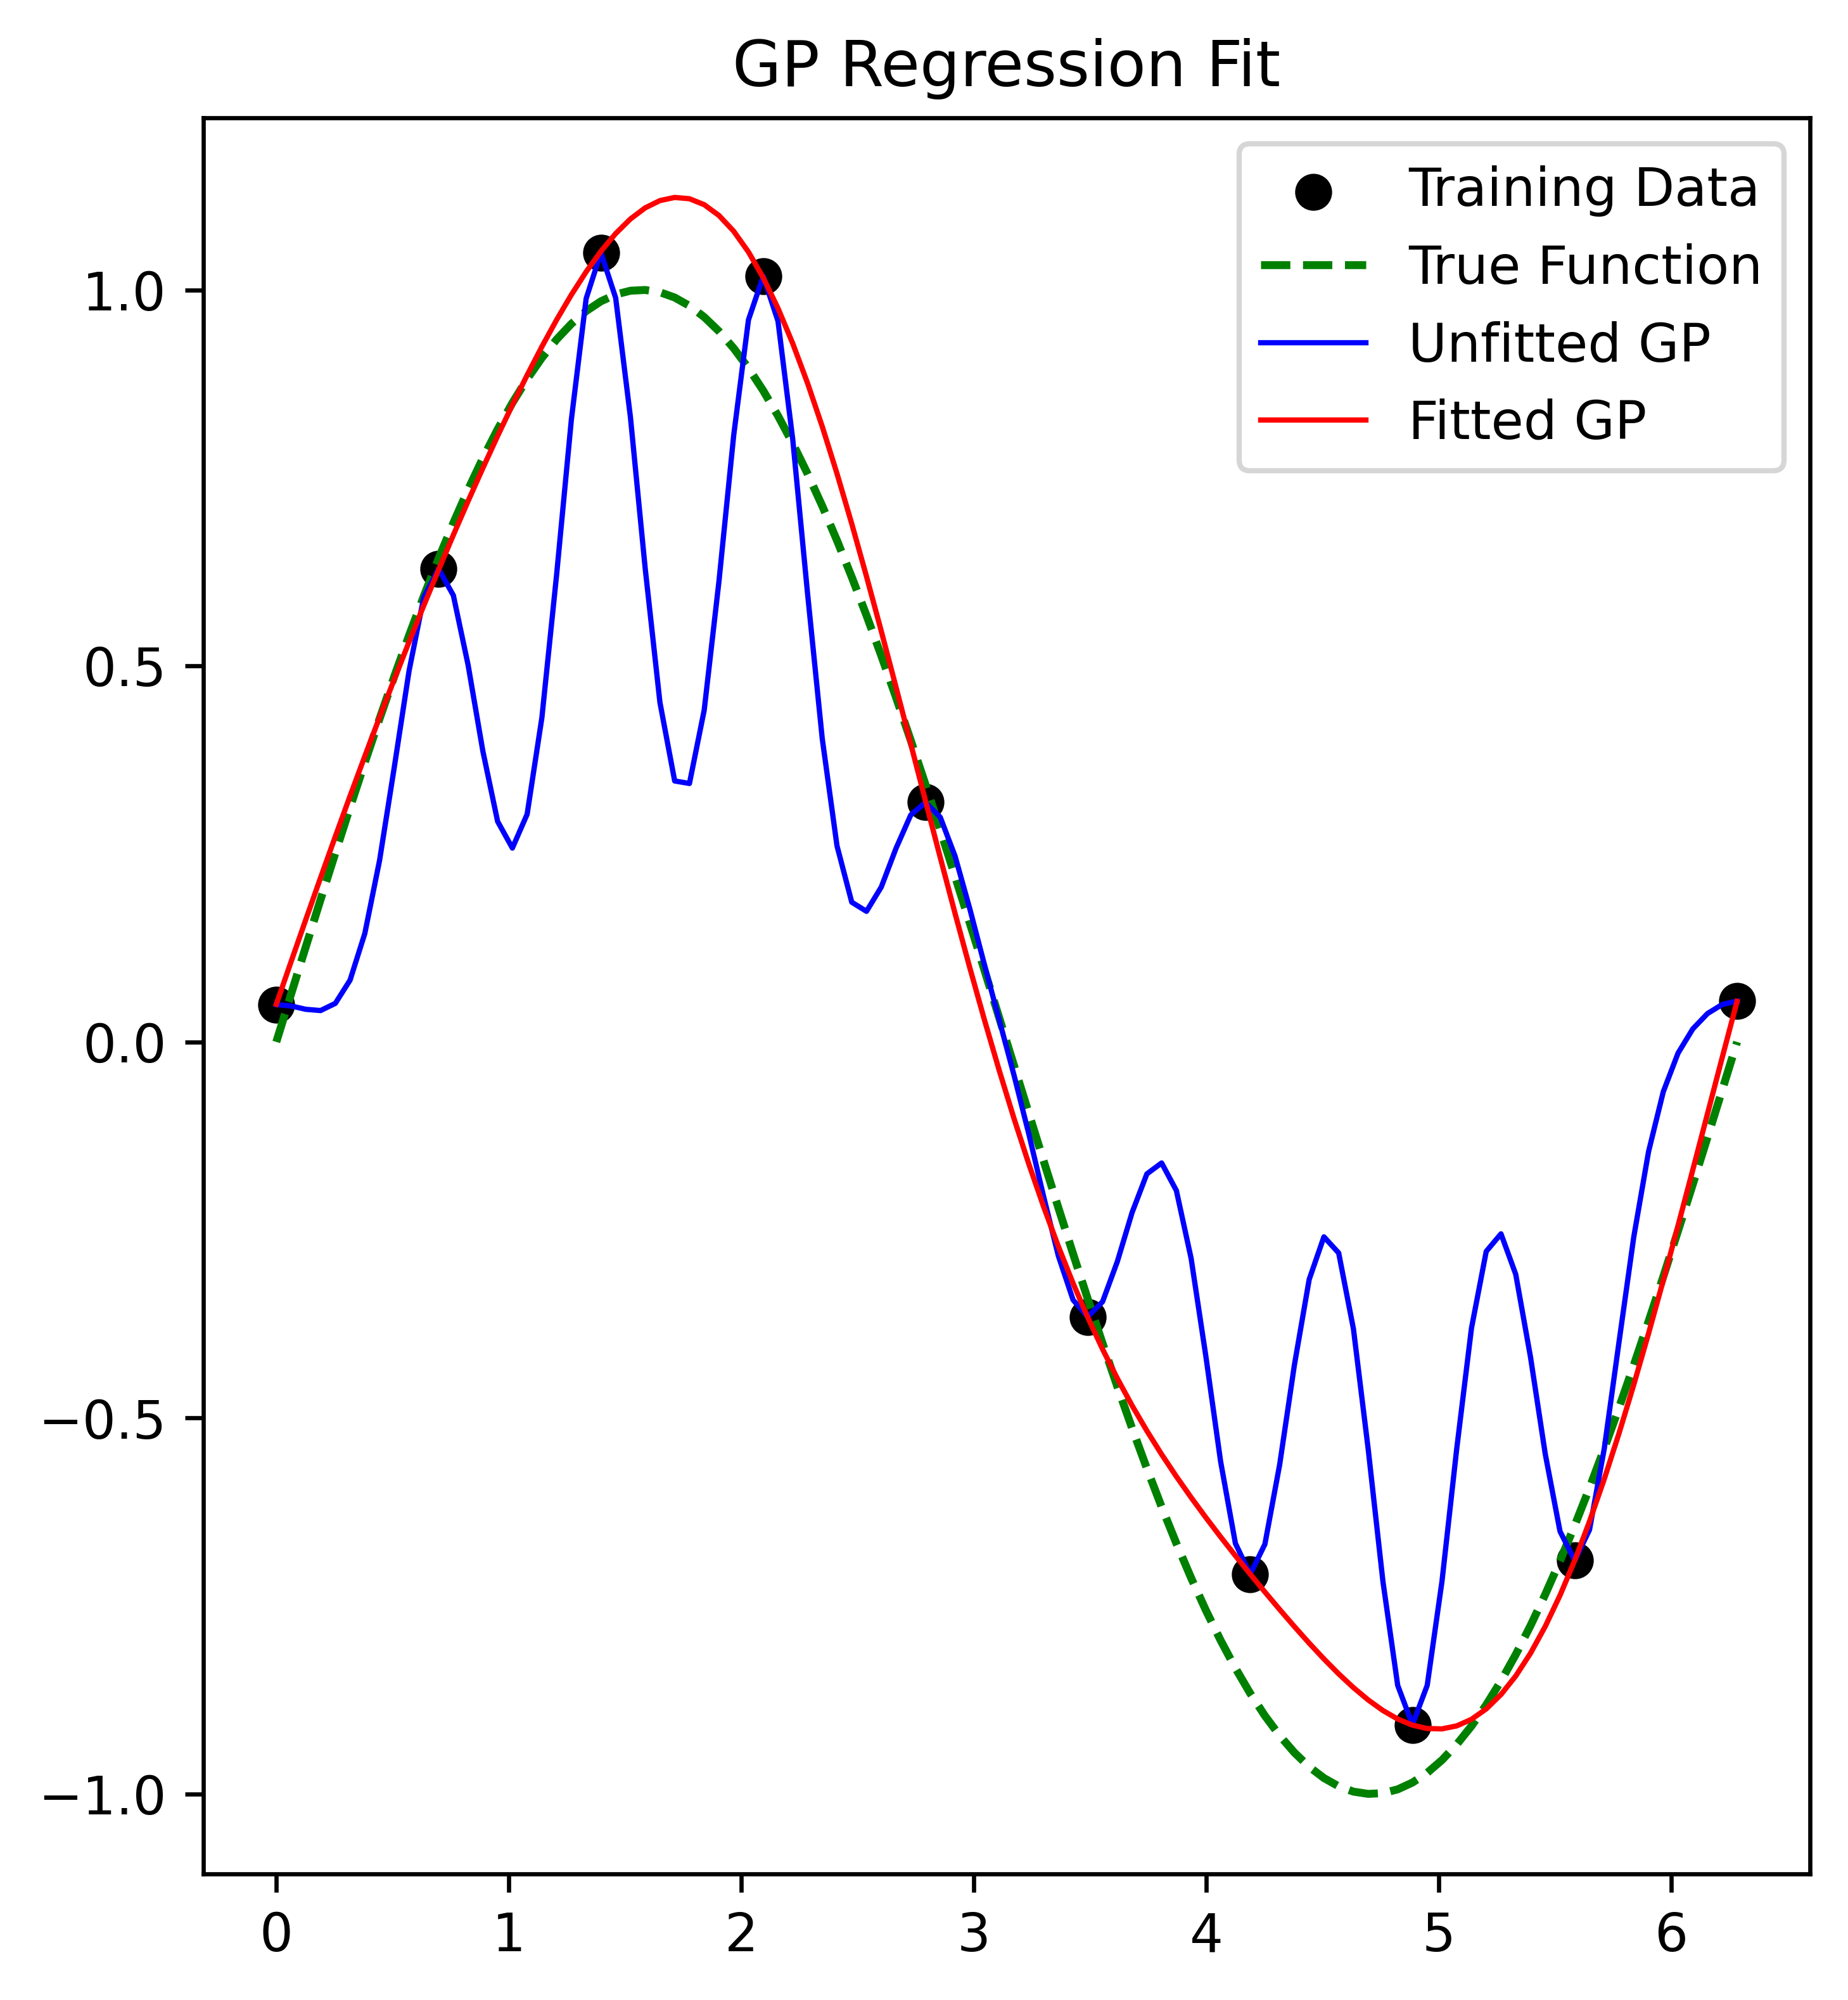

In [ ]:
# Tuning plot
plt.subplot(1, 2, 1)
plt.scatter(X, y, c="k", label="Training Data")
plt.plot(X_test, np.sin(X_test), "g--", label="True Function")
plt.plot(X_test, mu_initial, "b-", lw=1, label="Unfitted GP")
# plt.fill_between(X_test.ravel(), mu_initial-2*std_initial, mu_initial+2*std_initial, alpha=0.1)
plt.plot(X_test, mu_opt, "r-", lw=1, label="Fitted GP")
# plt.fill_between(X_test.ravel(), mu_opt-2*std_opt, mu_opt+2*std_opt, alpha=0.1)
plt.title("GP Regression Fit")
plt.legend()

/tmp/ipython-input-2217837085.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nll[i, j] = neg_log_likelihood(params, X, y)


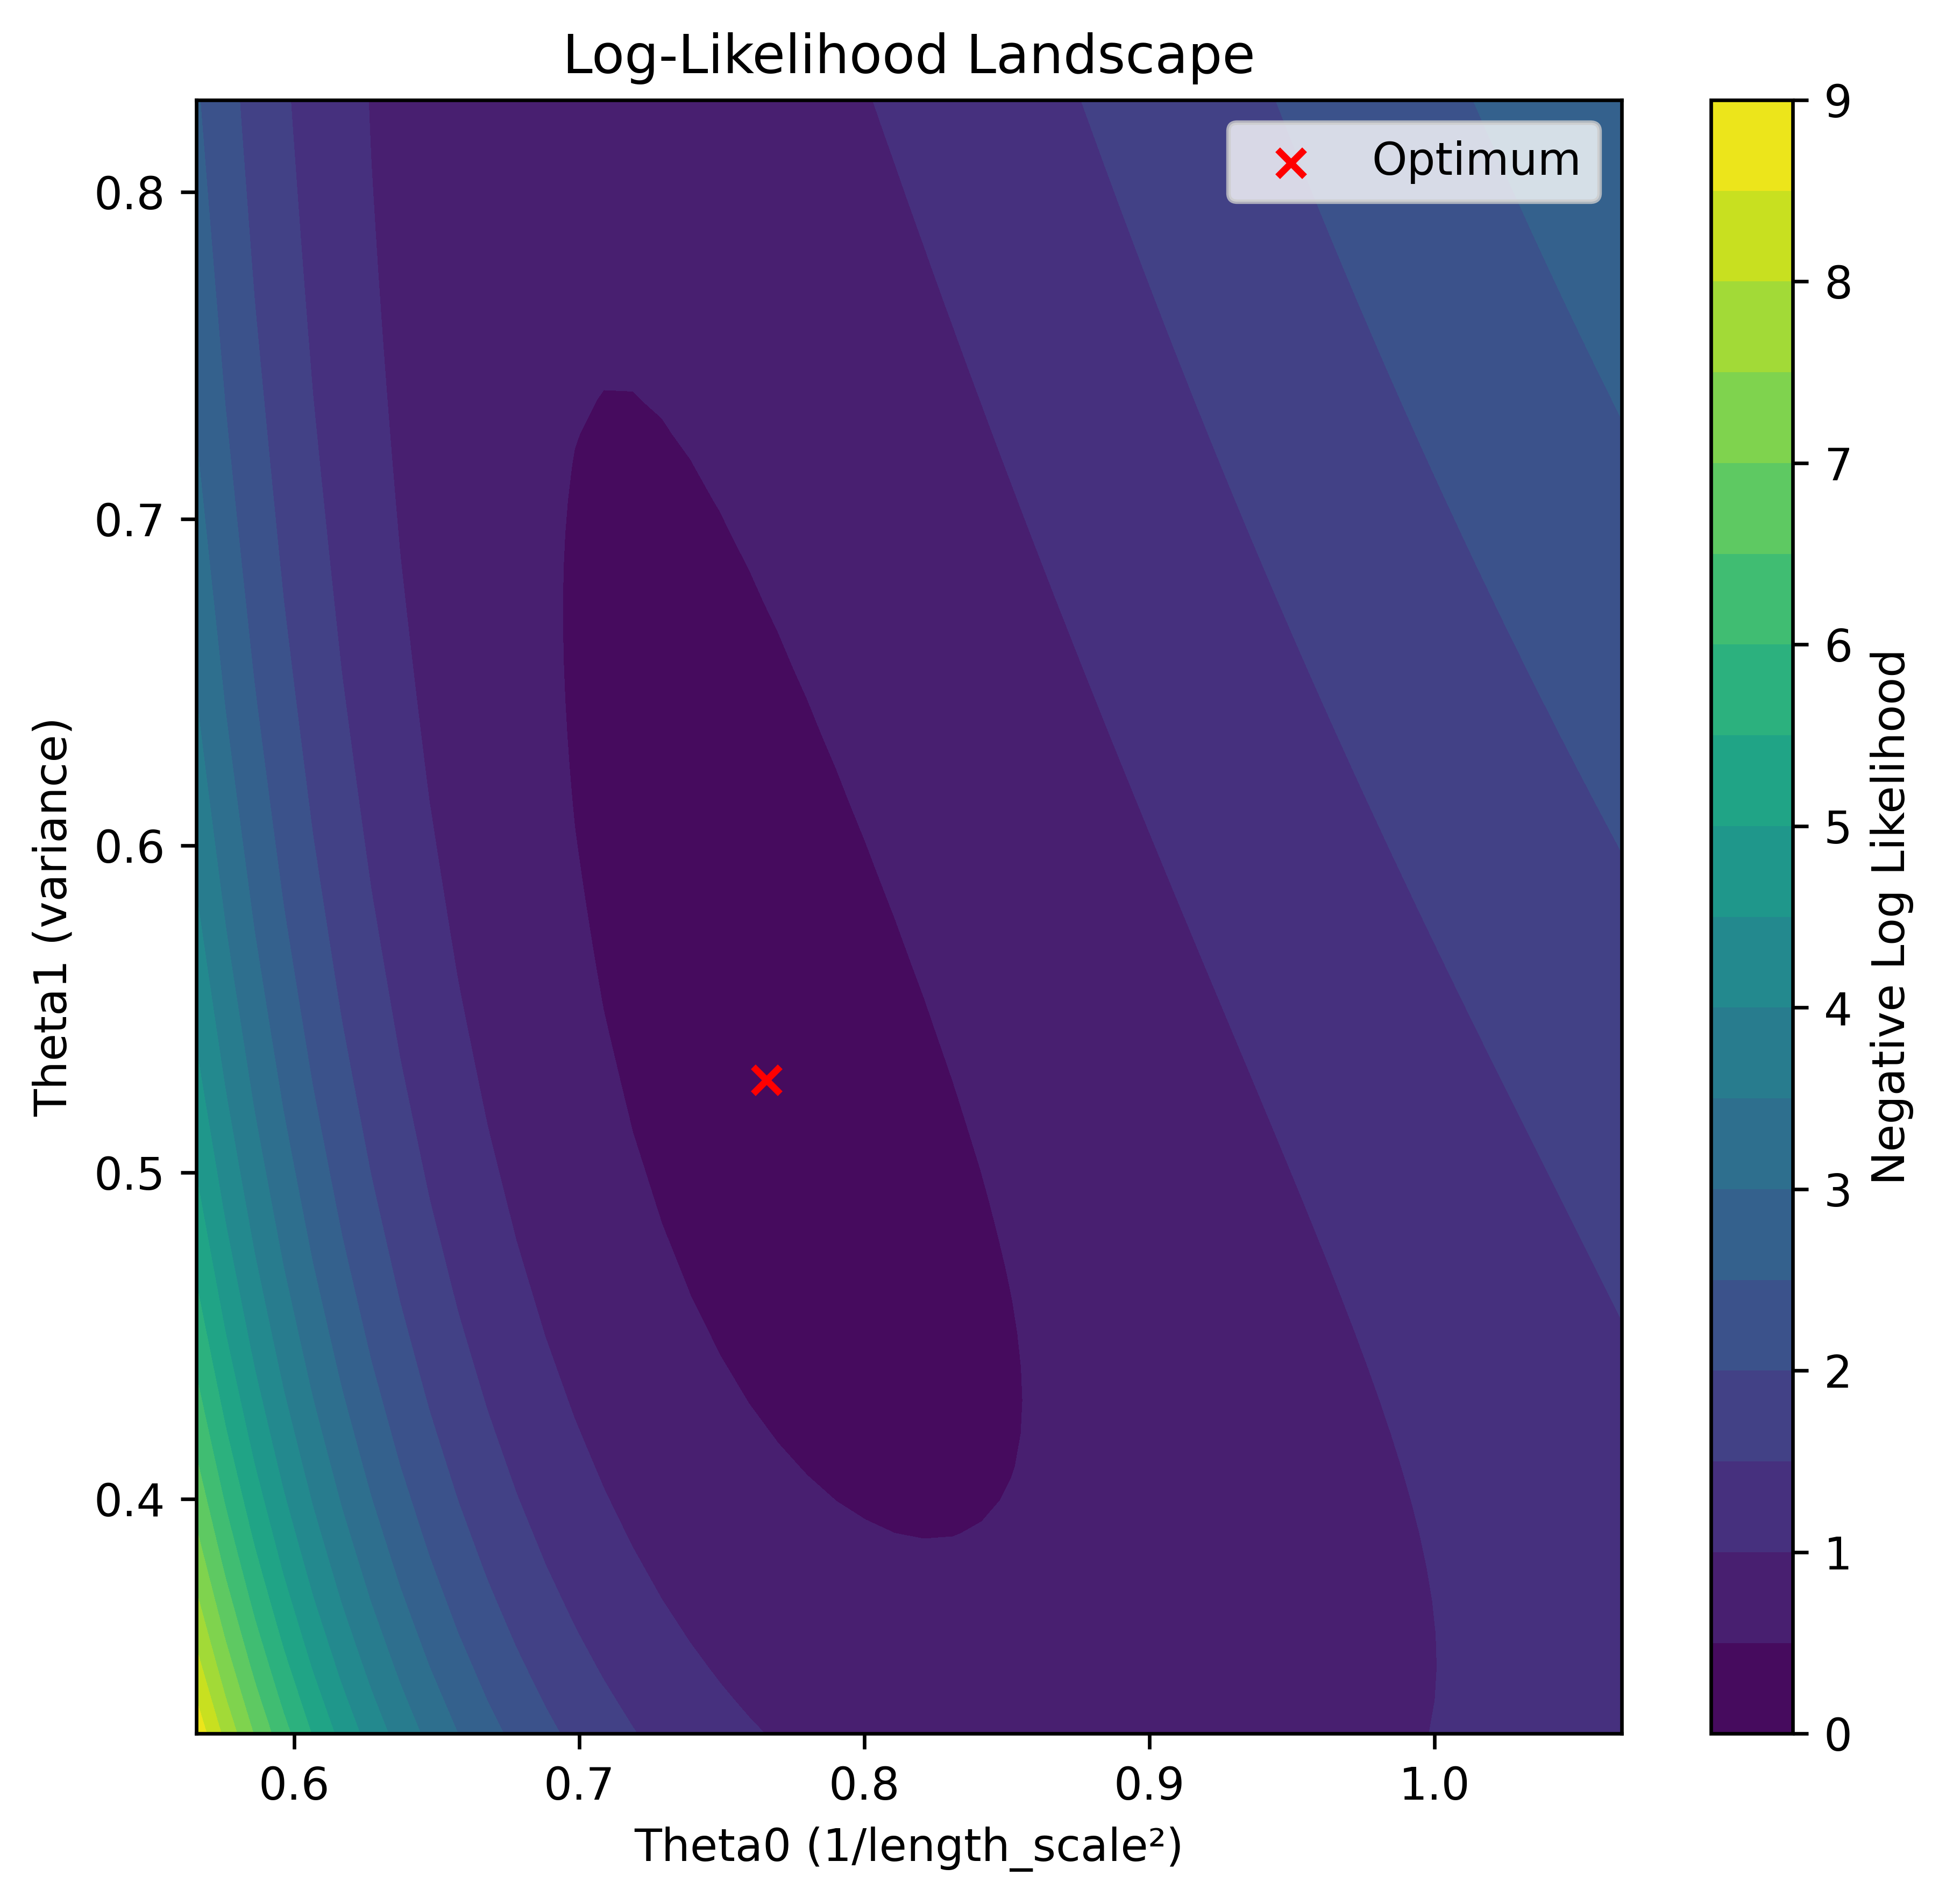

In [ ]:
plt.subplot(1, 2, 2)
theta0_grid = np.linspace(theta_opt[0] - 0.2, theta_opt[0] + 0.3, 50)
theta1_grid = np.linspace(theta_opt[1] - 0.2, theta_opt[1] + 0.3, 50)
Theta0, Theta1 = np.meshgrid(theta0_grid, theta1_grid)
nll = np.zeros_like(Theta0)

for i in range(Theta0.shape[0]):
    for j in range(Theta0.shape[1]):
        params = [Theta0[i, j], Theta1[i, j], noise_opt]
        nll[i, j] = neg_log_likelihood(params, X, y)

plt.contourf(Theta0, Theta1, nll, levels=20, cmap="viridis")
plt.colorbar(label="Negative Log Likelihood")
plt.scatter(*theta_opt, c="red", marker="x", label="Optimum")
plt.xlabel("Theta0 (1/length_scale²)")
plt.ylabel("Theta1 (variance)")
plt.title("Log-Likelihood Landscape")
plt.legend()

plt.tight_layout()
plt.show()

### Reminder: Laplace Approximation

In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

a = 4
scale = 1
loc = 0
# target_dist = stats.gamma(a=a, scale=scale)
target_dist = stats.skewnorm(a, loc, scale)


def neg_log_p(x):
    return -target_dist.logpdf(x)


result = minimize(neg_log_p, x0=np.array([1.0]), method="BFGS")
mode = result.x[0]
print(f"Mode found at: {mode:.4f}")

Mode found at: 0.4170


$f'(x) = \frac{f(x + h) - f(x)}{h}$

$f''(x) = \frac{f(x + h) - 2f(x) + f(x-h)}{h^2}$

In [ ]:
# Compute the second derivative of the log-density at the mode numerically
h = 1e-5

log_p_plus = target_dist.logpdf(mode + h)
log_p_minus = target_dist.logpdf(mode - h)
log_p_val = target_dist.logpdf(mode)

deriv2 = (log_p_plus - 2 * log_p_val + log_p_minus) / h**2
print(f"Second derivative at mode: {deriv2:.4f}")

Second derivative at mode: -3.9557


Laplace approximation variance: 0.2528


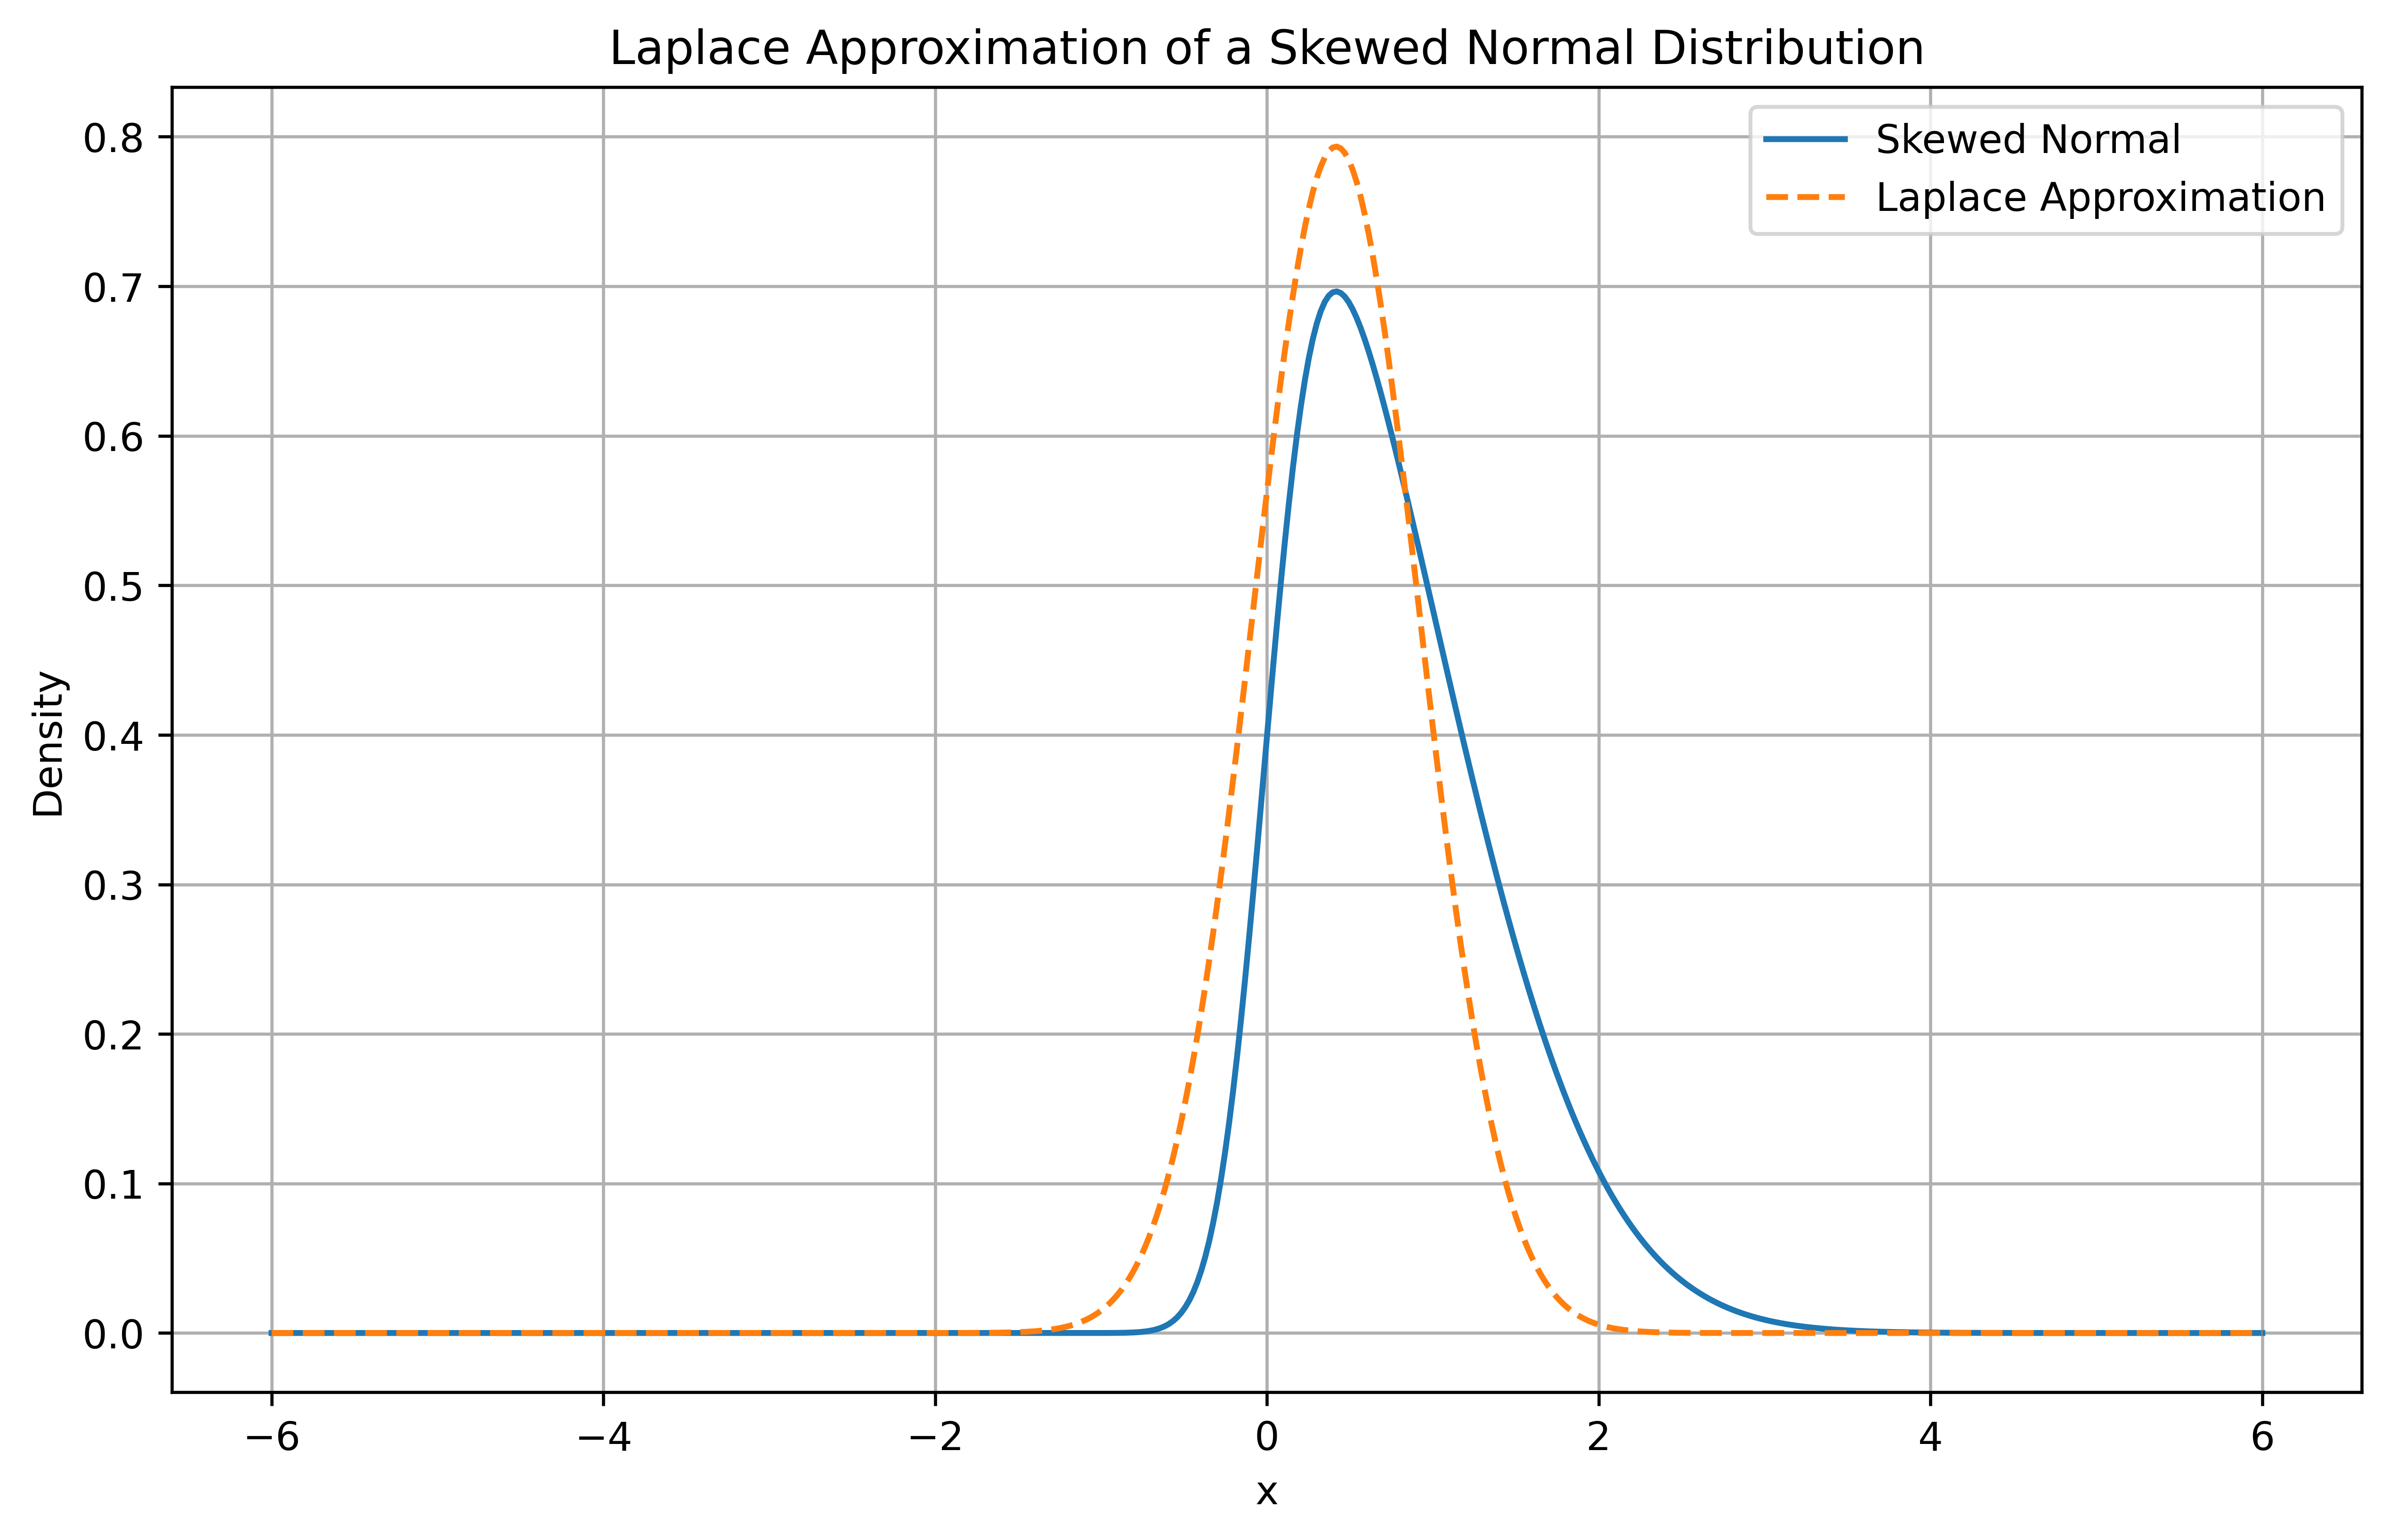

In [ ]:
var_laplace = -1 / deriv2
std_laplace = np.sqrt(var_laplace)
print(f"Laplace approximation variance: {var_laplace:.4f}")

laplace_approx = stats.norm(loc=mode, scale=std_laplace)

# Plot both distributions
x = np.linspace(-6, 6, 500)
plt.figure(figsize=(10, 6))
plt.plot(x, target_dist.pdf(x), label="Skewed Normal")
plt.plot(x, laplace_approx.pdf(x), "--", label="Laplace Approximation")
plt.title("Laplace Approximation of a Skewed Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## GP for classification



In [ ]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label="Mean")
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls="--", label=f"Sample {i+1}")
    if X_train is not None:
        plt.plot(X_train, Y_train, "rx")
    plt.legend()


def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection="3d")
    ax.plot_surface(
        gx,
        gy,
        mu.reshape(gx.shape),
        cmap=cm.coolwarm,
        linewidth=0,
        alpha=0.2,
        antialiased=False,
    )
    ax.scatter(X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)


def plot_data_1D(X, t):
    class_0 = t == 0
    class_1 = t == 1

    plt.scatter(X[class_1], t[class_1], label="Class 1", marker="x", color="red")
    plt.scatter(
        X[class_0],
        t[class_0],
        label="Class 0",
        marker="o",
        edgecolors="blue",
        facecolors="none",
    )


def plot_data_2D(X, t):
    class_1 = np.ravel(t == 1)
    class_0 = np.ravel(t == 0)

    plt.scatter(X[class_1, 0], X[class_1, 1], label="Class 1", marker="x", c="red")
    plt.scatter(
        X[class_0, 0],
        X[class_0, 1],
        label="Class 0",
        marker="o",
        edgecolors="blue",
        facecolors="none",
    )

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")


def plot_py_2D(grid_x, grid_y, grid_z):
    plt.contourf(
        grid_x, grid_y, grid_z, cmap="plasma", alpha=0.3, levels=np.linspace(0, 1, 11)
    )
    plt.colorbar(format="%.2f")


def plot_db_2D(grid_x, grid_y, grid_z, decision_boundary=0.5):
    levels = [decision_boundary]
    cs = plt.contour(
        grid_x,
        grid_y,
        grid_z,
        levels=levels,
        colors="black",
        linestyles="dashed",
        linewidths=2,
    )
    plt.clabel(cs, fontsize=20)

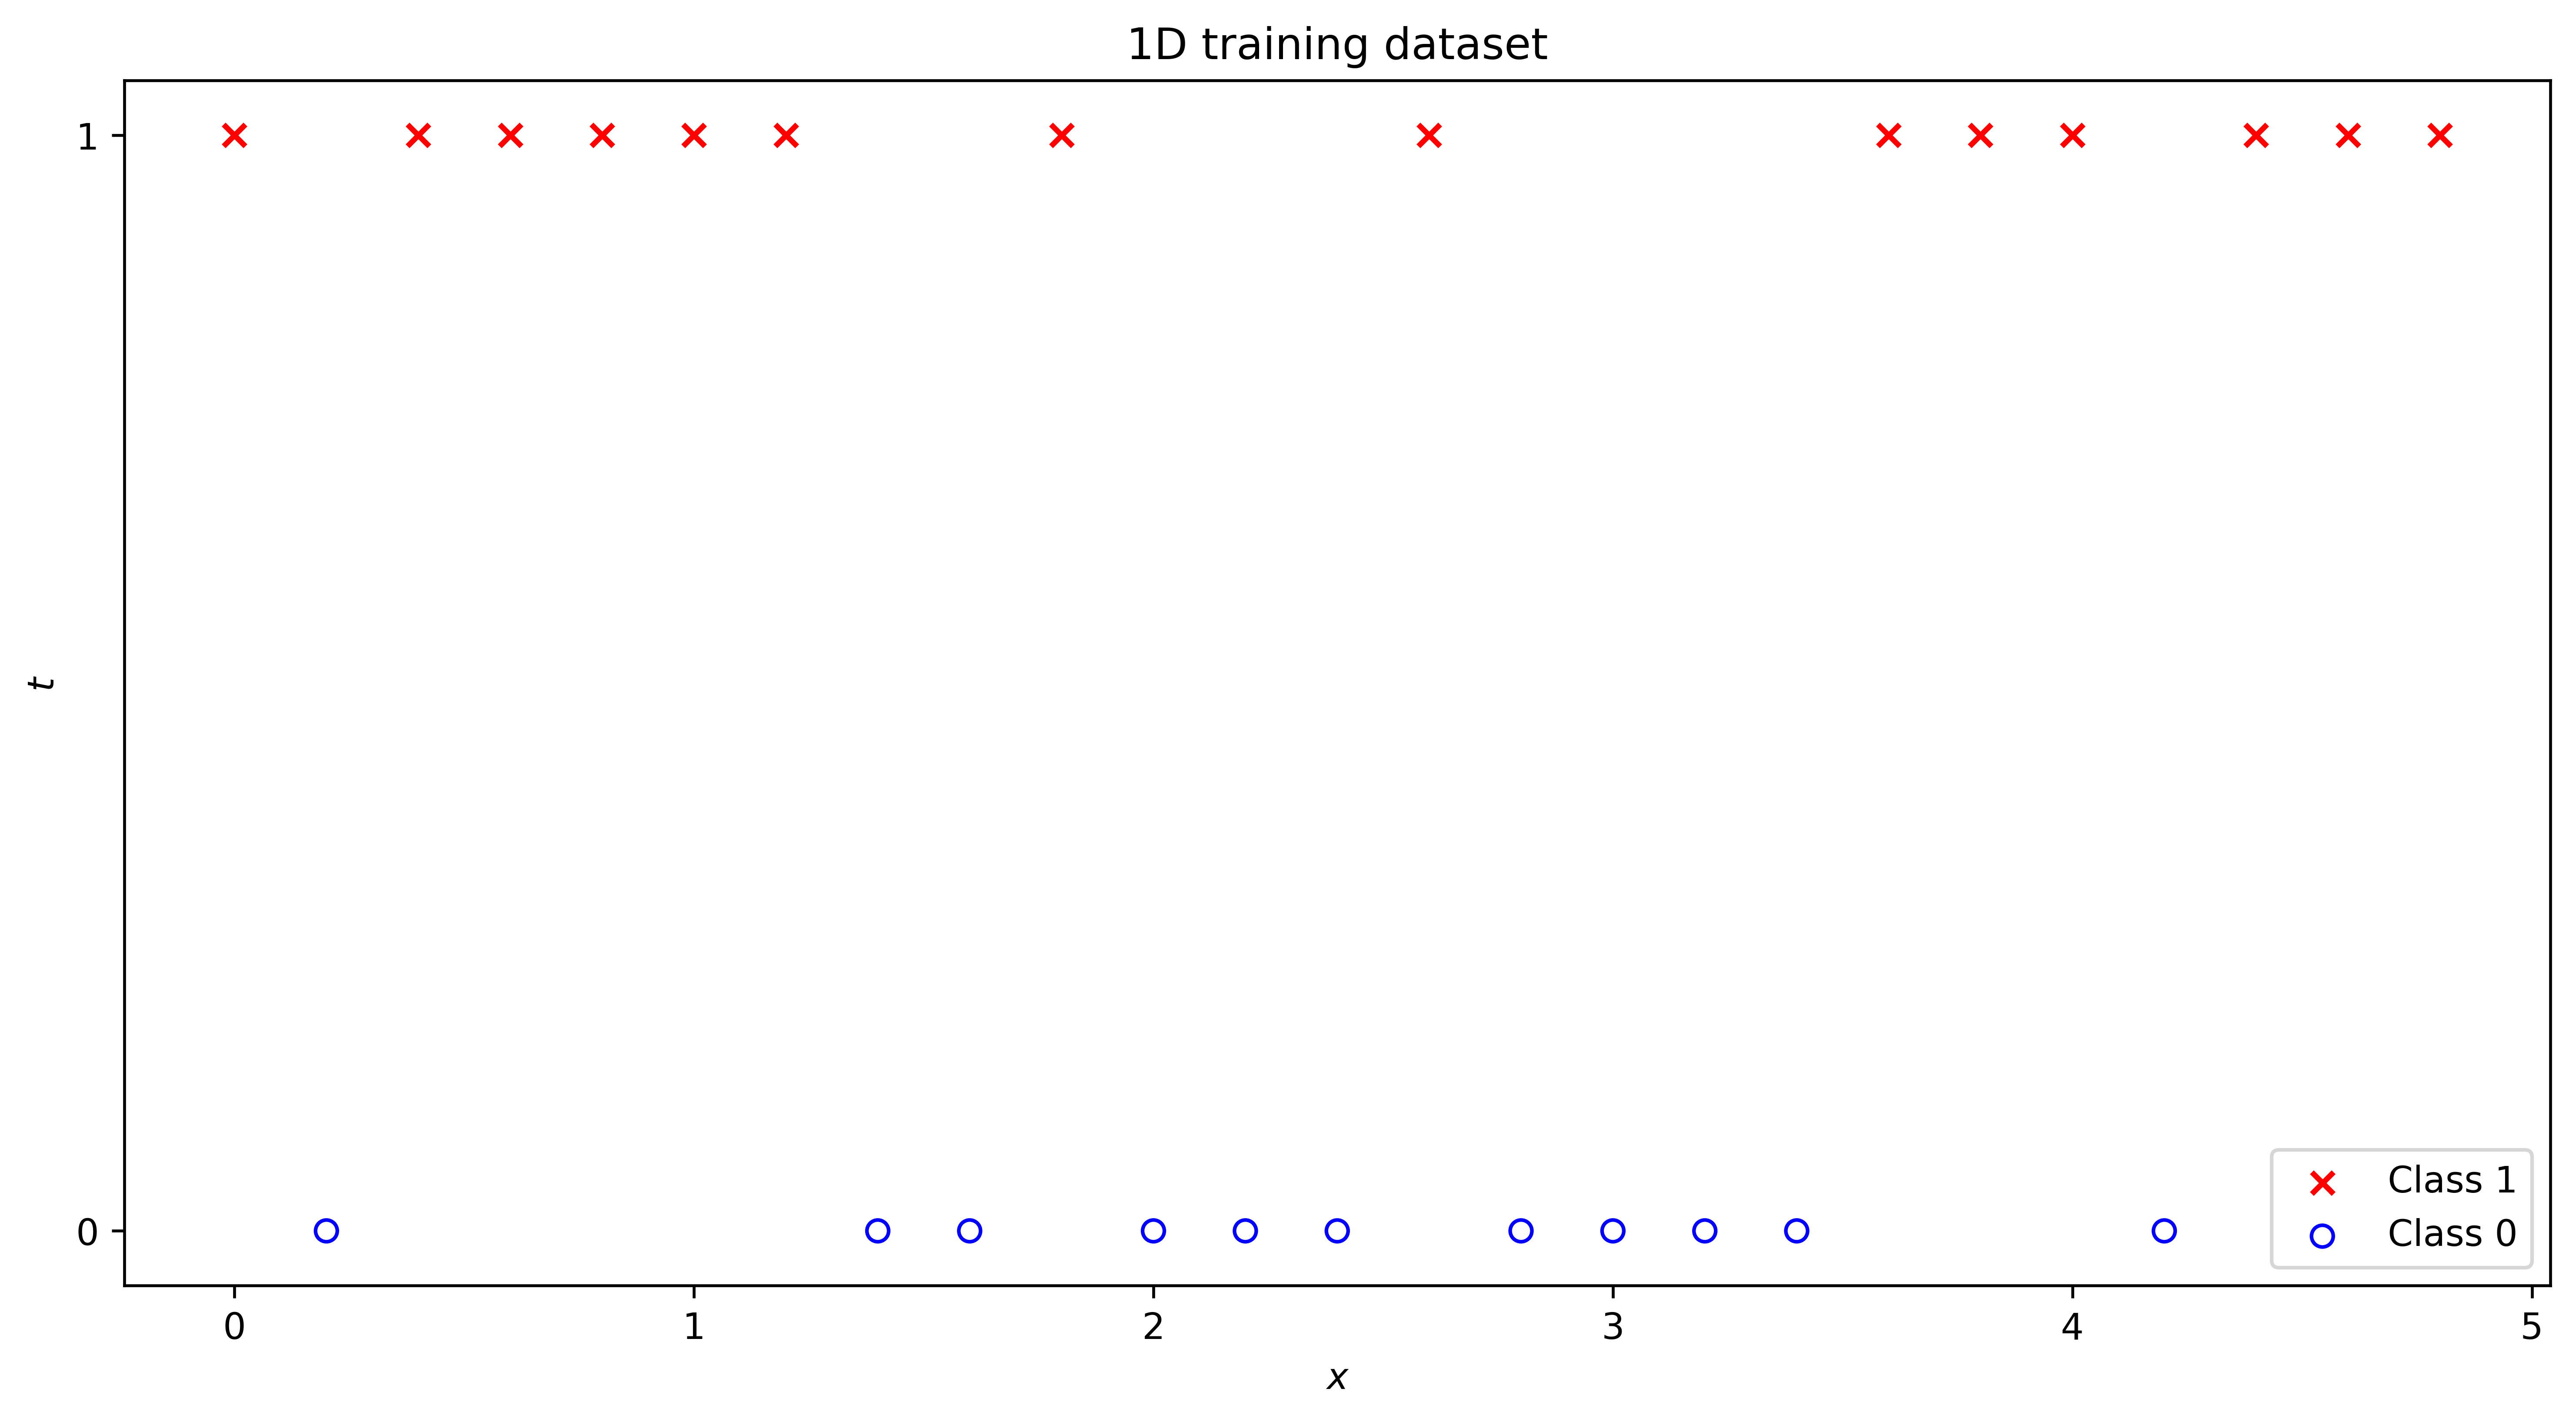

In [ ]:
np.random.seed(0)

X = np.arange(0, 5, 0.2).reshape(-1, 1)
X_test = np.arange(-2, 7, 0.1).reshape(-1, 1)

a = np.sin(X * np.pi * 0.5) * 2
y = bernoulli.rvs(sigmoid(a))

plot_data_1D(X, y)
plt.title("1D training dataset")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.yticks([0, 1])
plt.legend();

In [ ]:
def K_(X, theta, diag_only=False, nu=1e-5):
    """K + \nu I"""
    if diag_only:
        # Specific solution for isotropic squared exponential kernel.
        return theta[1] ** 2 + nu
    else:
        return kernel(X, X, theta) + nu * np.eye(X.shape[0])


def W_(a):
    """W"""
    r = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(r.ravel())

In [ ]:
def posterior_mode(X, y, K, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(f|y).
    """
    f = np.zeros_like(y)
    I = np.eye(X.shape[0])

    for i in range(max_iter):
        W = W_(f)
        Q_inv = np.linalg.inv(I + W @ K)
        f_new = (K @ Q_inv).dot(y - sigmoid(f) + W.dot(f))
        f_diff = np.abs(f_new - f)
        f = f_new

        if not np.any(f_diff > tol):
            break

    return f

In [ ]:
def nll_fn(X, y):
    """
    Returns the negative log-likelihood function for data X, y.
    P(y |X) as a function of theta
    """

    y = y.ravel()

    def nll(theta):
        K_f = K_(X, theta)
        K_f_inv = np.linalg.inv(K_f)

        f_h = posterior_mode(X, y, K_f).ravel()
        W = W_(f_h)

        ll = (
            -0.5 * f_h.T.dot(K_f_inv).dot(f_h)
            - 0.5 * np.linalg.slogdet(K_f)[1]
            - 0.5 * np.linalg.slogdet(W + K_f_inv)[1]
            + y.dot(f_h)
            - np.sum(np.log(1 + np.exp(f_h)))
        )

        return -ll

    return nll

In [ ]:
res = minimize(
    nll_fn(X, y), [1, 1], bounds=((1e-3, None), (1e-3, None)), method="L-BFGS-B"
)

theta = res.x

print(
    f"Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}"
)

Optimized theta = [1.953, 0.699], negative log likelihood = 17.002


In [ ]:
def predict_f(X_test, X, y, theta):
    """
    Computes the mean and variance of logits at points X_test
    given training data X, y and kernel parameters theta.
    """
    K = K_(X, theta)
    K_star = kernel(X, X_test, theta)
    K_star_star = kernel(X_test, X_test, theta)
    A = K_star.T @ np.linalg.inv(K)
    f = posterior_mode(X, y, K)

    H = np.linalg.inv(K) + W_(f)
    H_inv = np.linalg.inv(H)
    # W_inv = np.linalg(W_(f))
    # R_inv = np.linalg(W_inv + K)

    f_test_mu = A.dot(f)

    Sigma = K_(X_test, theta, diag_only=True) + A @ H_inv @ A.T

    f_test_var2 = np.diag(Sigma).reshape(-1, 1)

    return f_test_mu, f_test_var2


def predict_py(X_test, X, y, theta):
    """
    Computes the probability of y=1 at points X_test
    given training data X, y and kernel parameters theta.
    """

    f_mu, f_var2 = predict_f(X_test, X, y, theta)

    kappa = 1.0 / np.sqrt(1 + np.pi * f_var2 / 8)

    return sigmoid(kappa * f_mu)

In [ ]:
f_mu, f_var2 = predict_f(X_test, X, y, theta)
f_mu.shape, f_var2.shape

((90, 1), (90, 1))

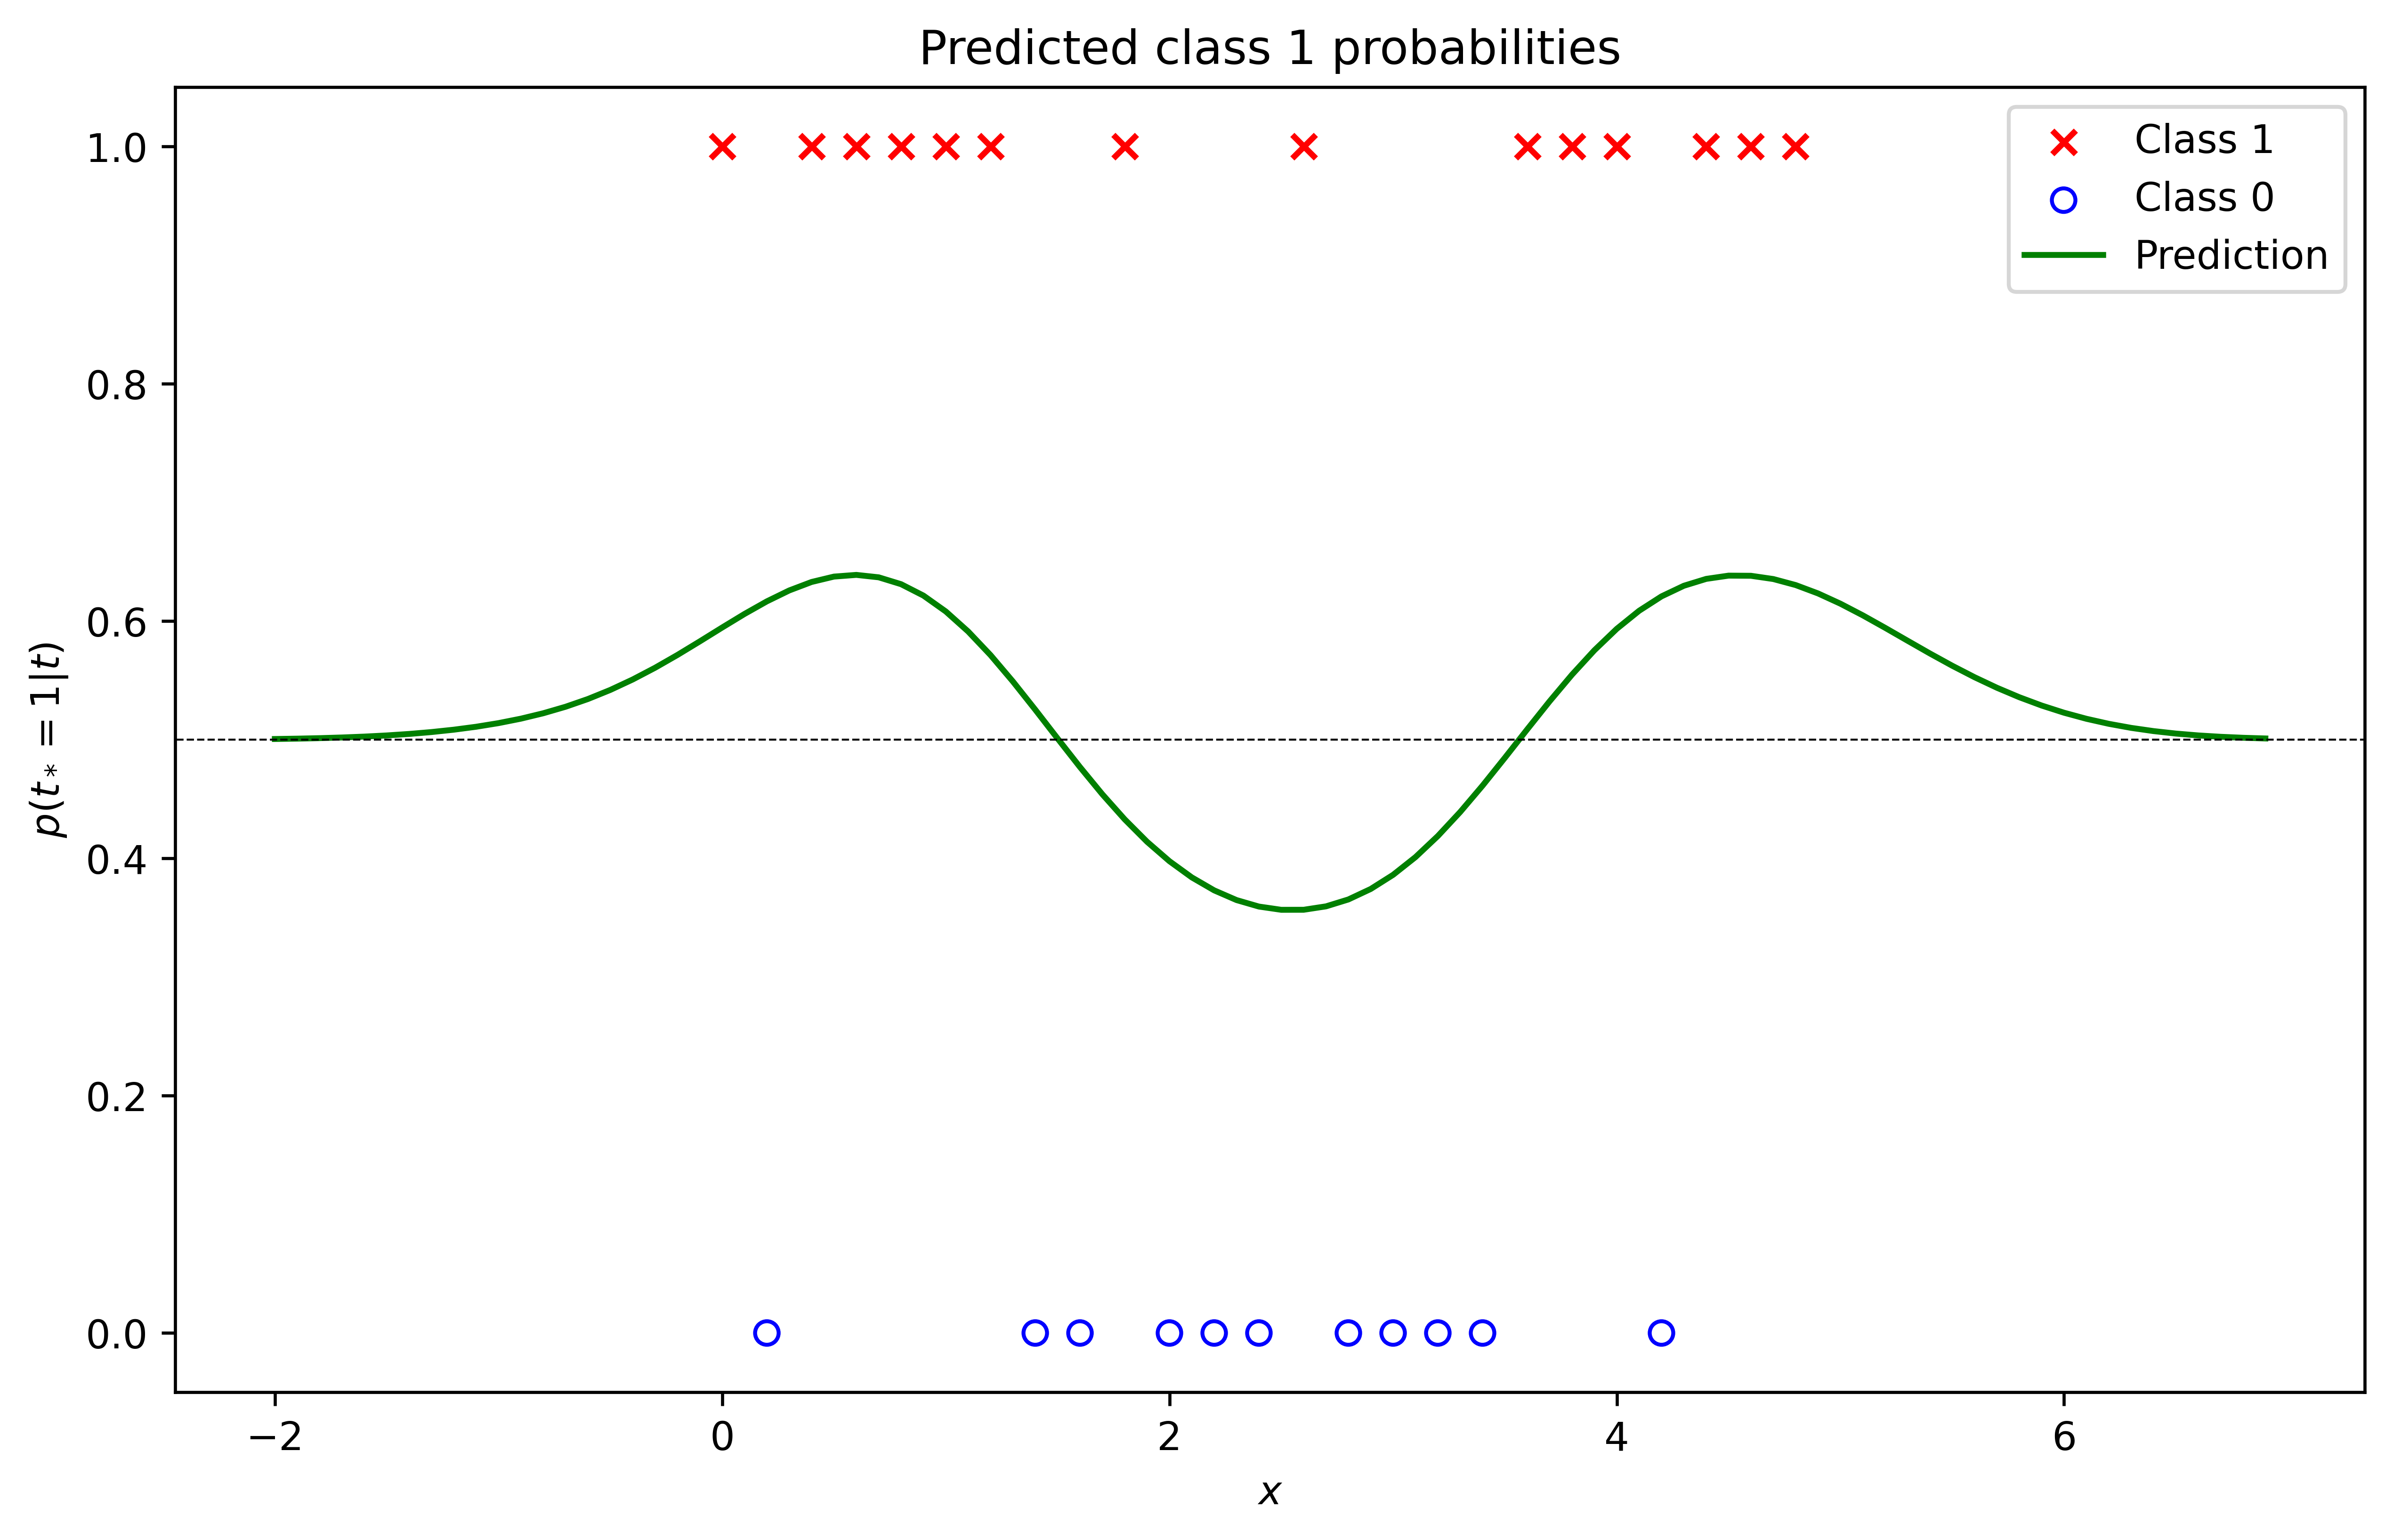

In [ ]:
pt_test = predict_py(X_test, X, y, theta)
pt_test.shape
plt.figure(figsize=(10, 6))

plot_data_1D(X, y)
plt.plot(X_test, pt_test, label="Prediction", color="green")

plt.axhline(0.5, X_test.min(), X_test.max(), color="black", ls="--", lw=0.5)
plt.title("Predicted class 1 probabilities")
plt.xlabel("$x$")
plt.ylabel("$p(t_*=1|t)$")
plt.legend();

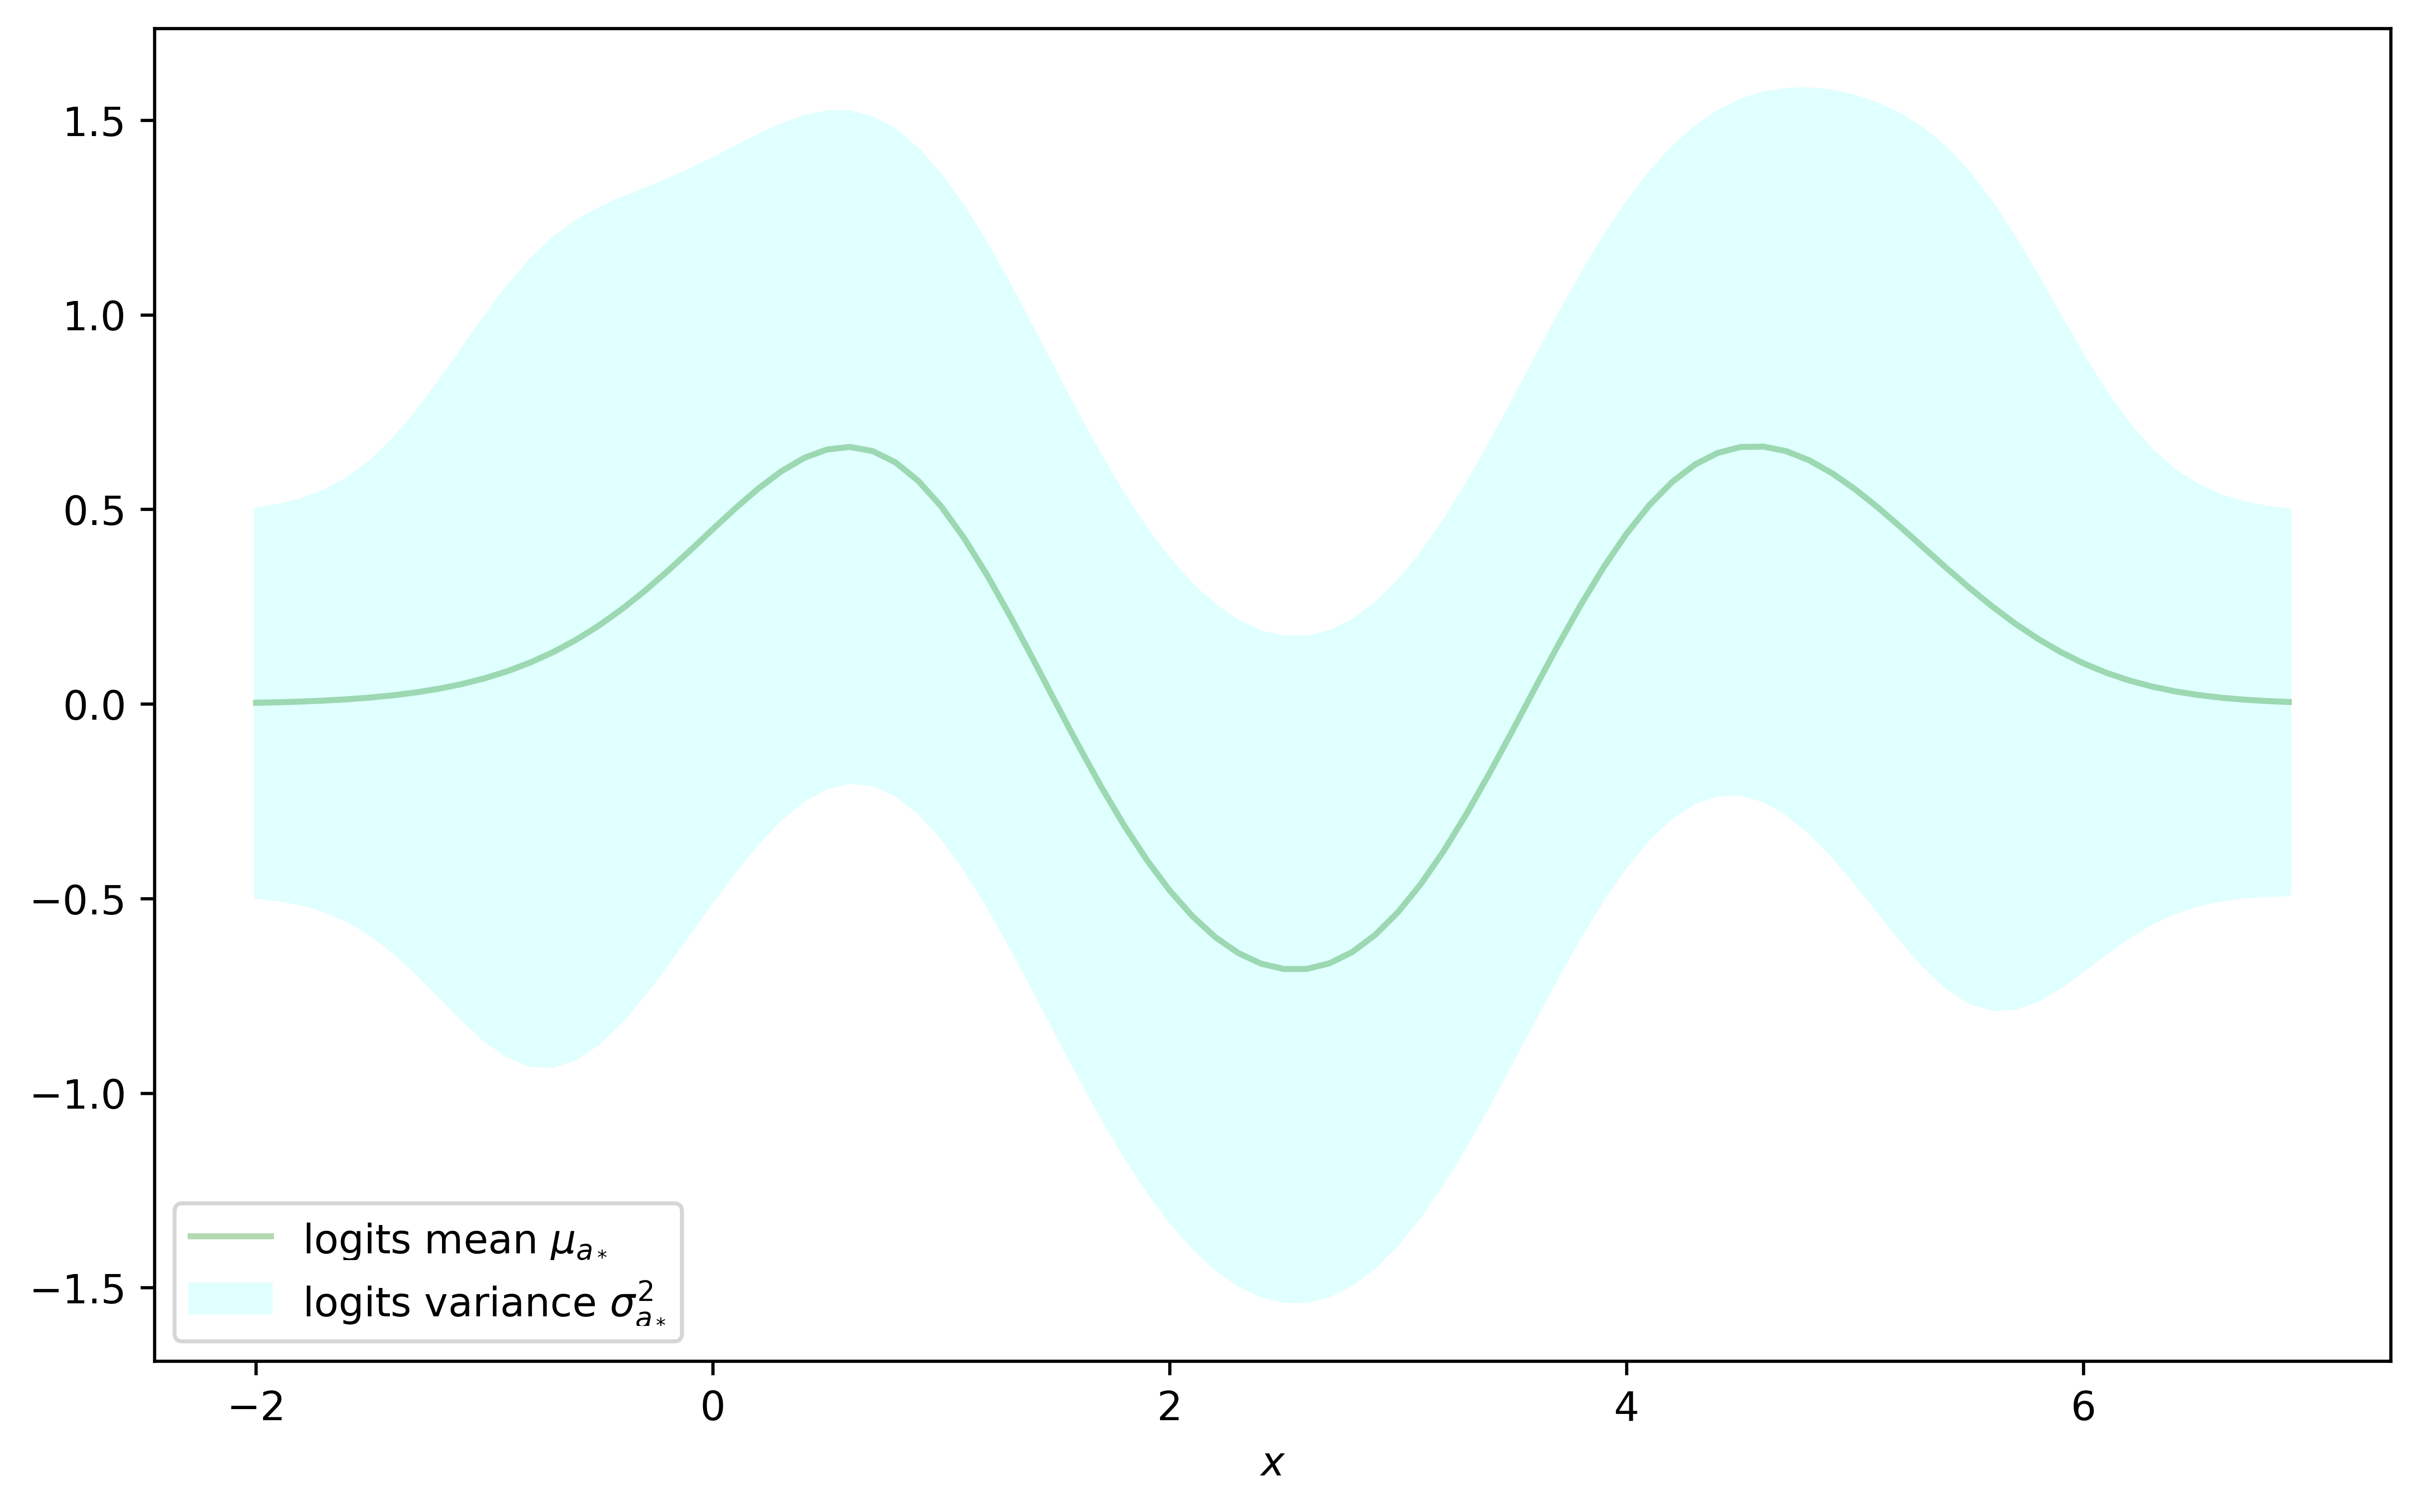

In [ ]:
f_test_mu, f_test_var = predict_f(X_test, X, y, theta)
f_test_mu = f_test_mu.ravel()
f_test_var = f_test_var.ravel()
plt.figure(figsize=(10, 6))

plt.plot(X_test, f_test_mu, label=r"logits mean $\mu_{a_*}$", color="green", alpha=0.3)
plt.fill_between(
    X_test.ravel(),
    f_test_mu + f_test_var,
    f_test_mu - f_test_var,
    label=r"logits variance $\sigma^2_{a_*}$",
    color="lightcyan",
)
plt.xlabel("$x$")
plt.legend();

## sklearn

In [ ]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, y.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()["length_scale"]
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()["constant_value"])

sklearn_theta_0, sklearn_theta_1, -gpc.log_marginal_likelihood_value_
print(
    f"Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}"
)

Optimized theta = [0.715, 0.836], negative log likelihood = 17.002


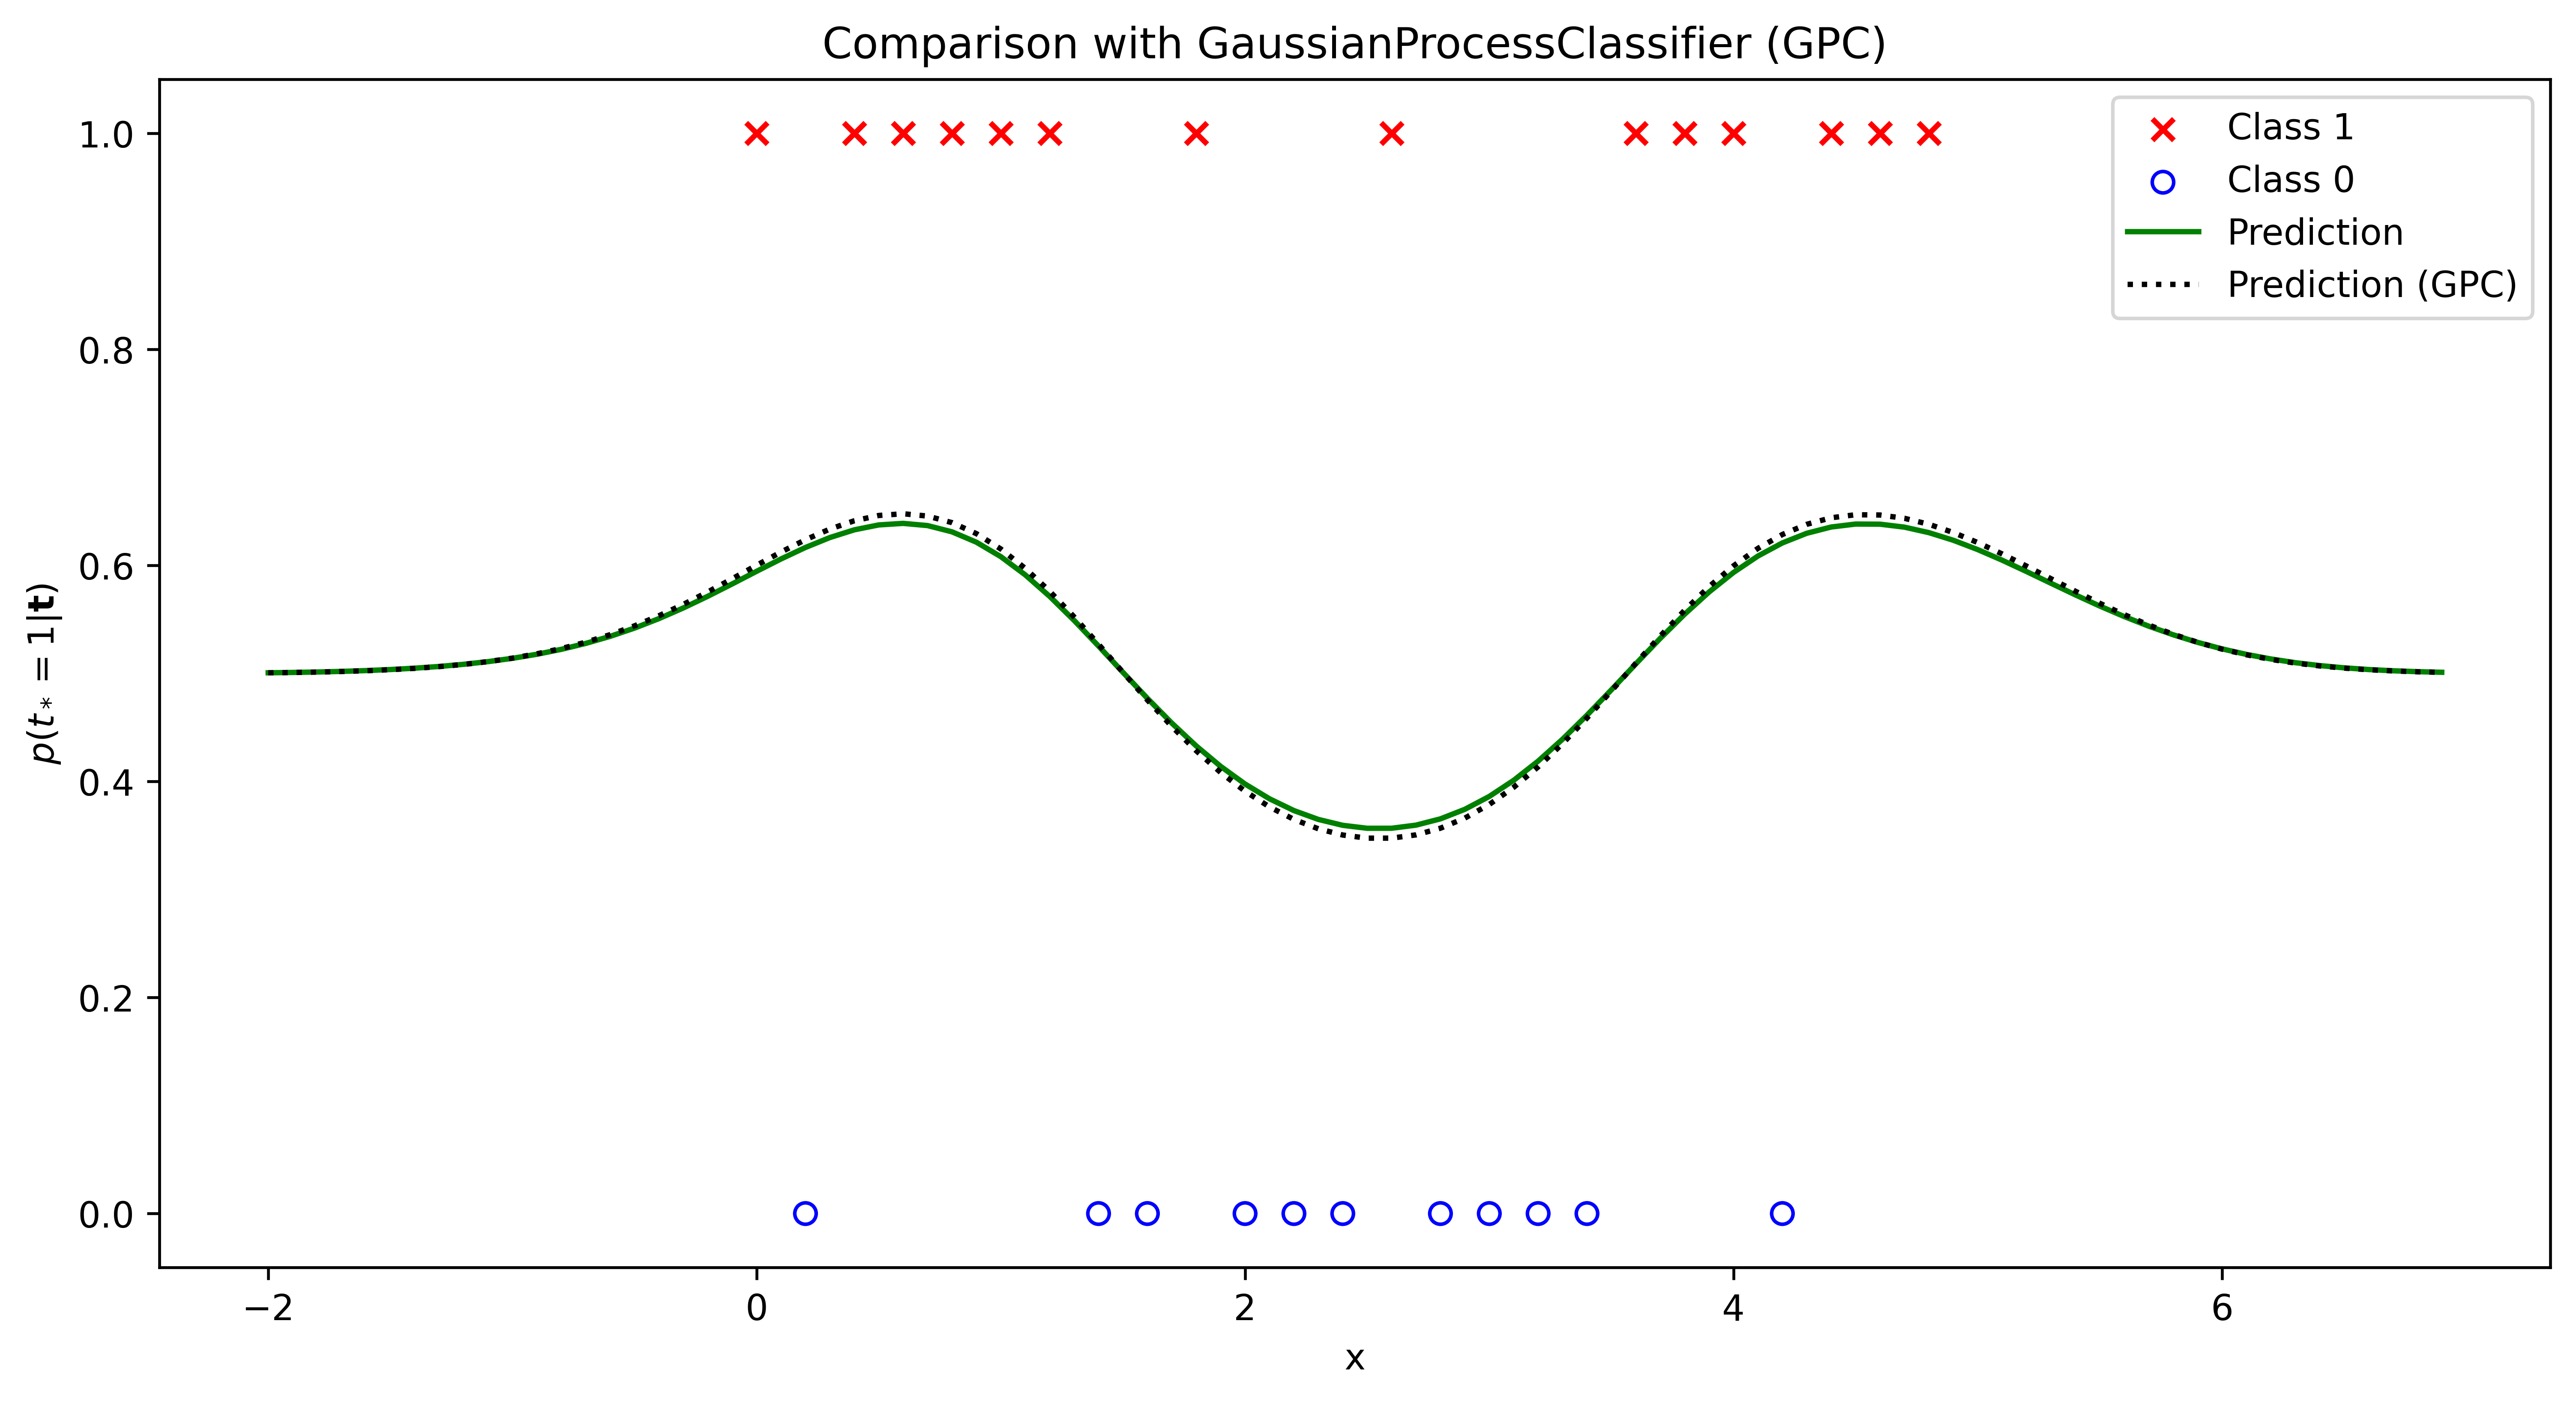

In [ ]:
pt_test_gpc = gpc.predict_proba(X_test.reshape(-1, 1))[:, 1]

plot_data_1D(X, y)
plt.plot(X_test, pt_test, label="Prediction", color="green")
plt.plot(X_test, pt_test_gpc, label="Prediction (GPC)", color="black", ls=":")
plt.title("Comparison with GaussianProcessClassifier (GPC)")
plt.xlabel("x")
plt.ylabel(r"$p(t_*=1|\mathbf{t})$")
plt.legend();

## 2D Example

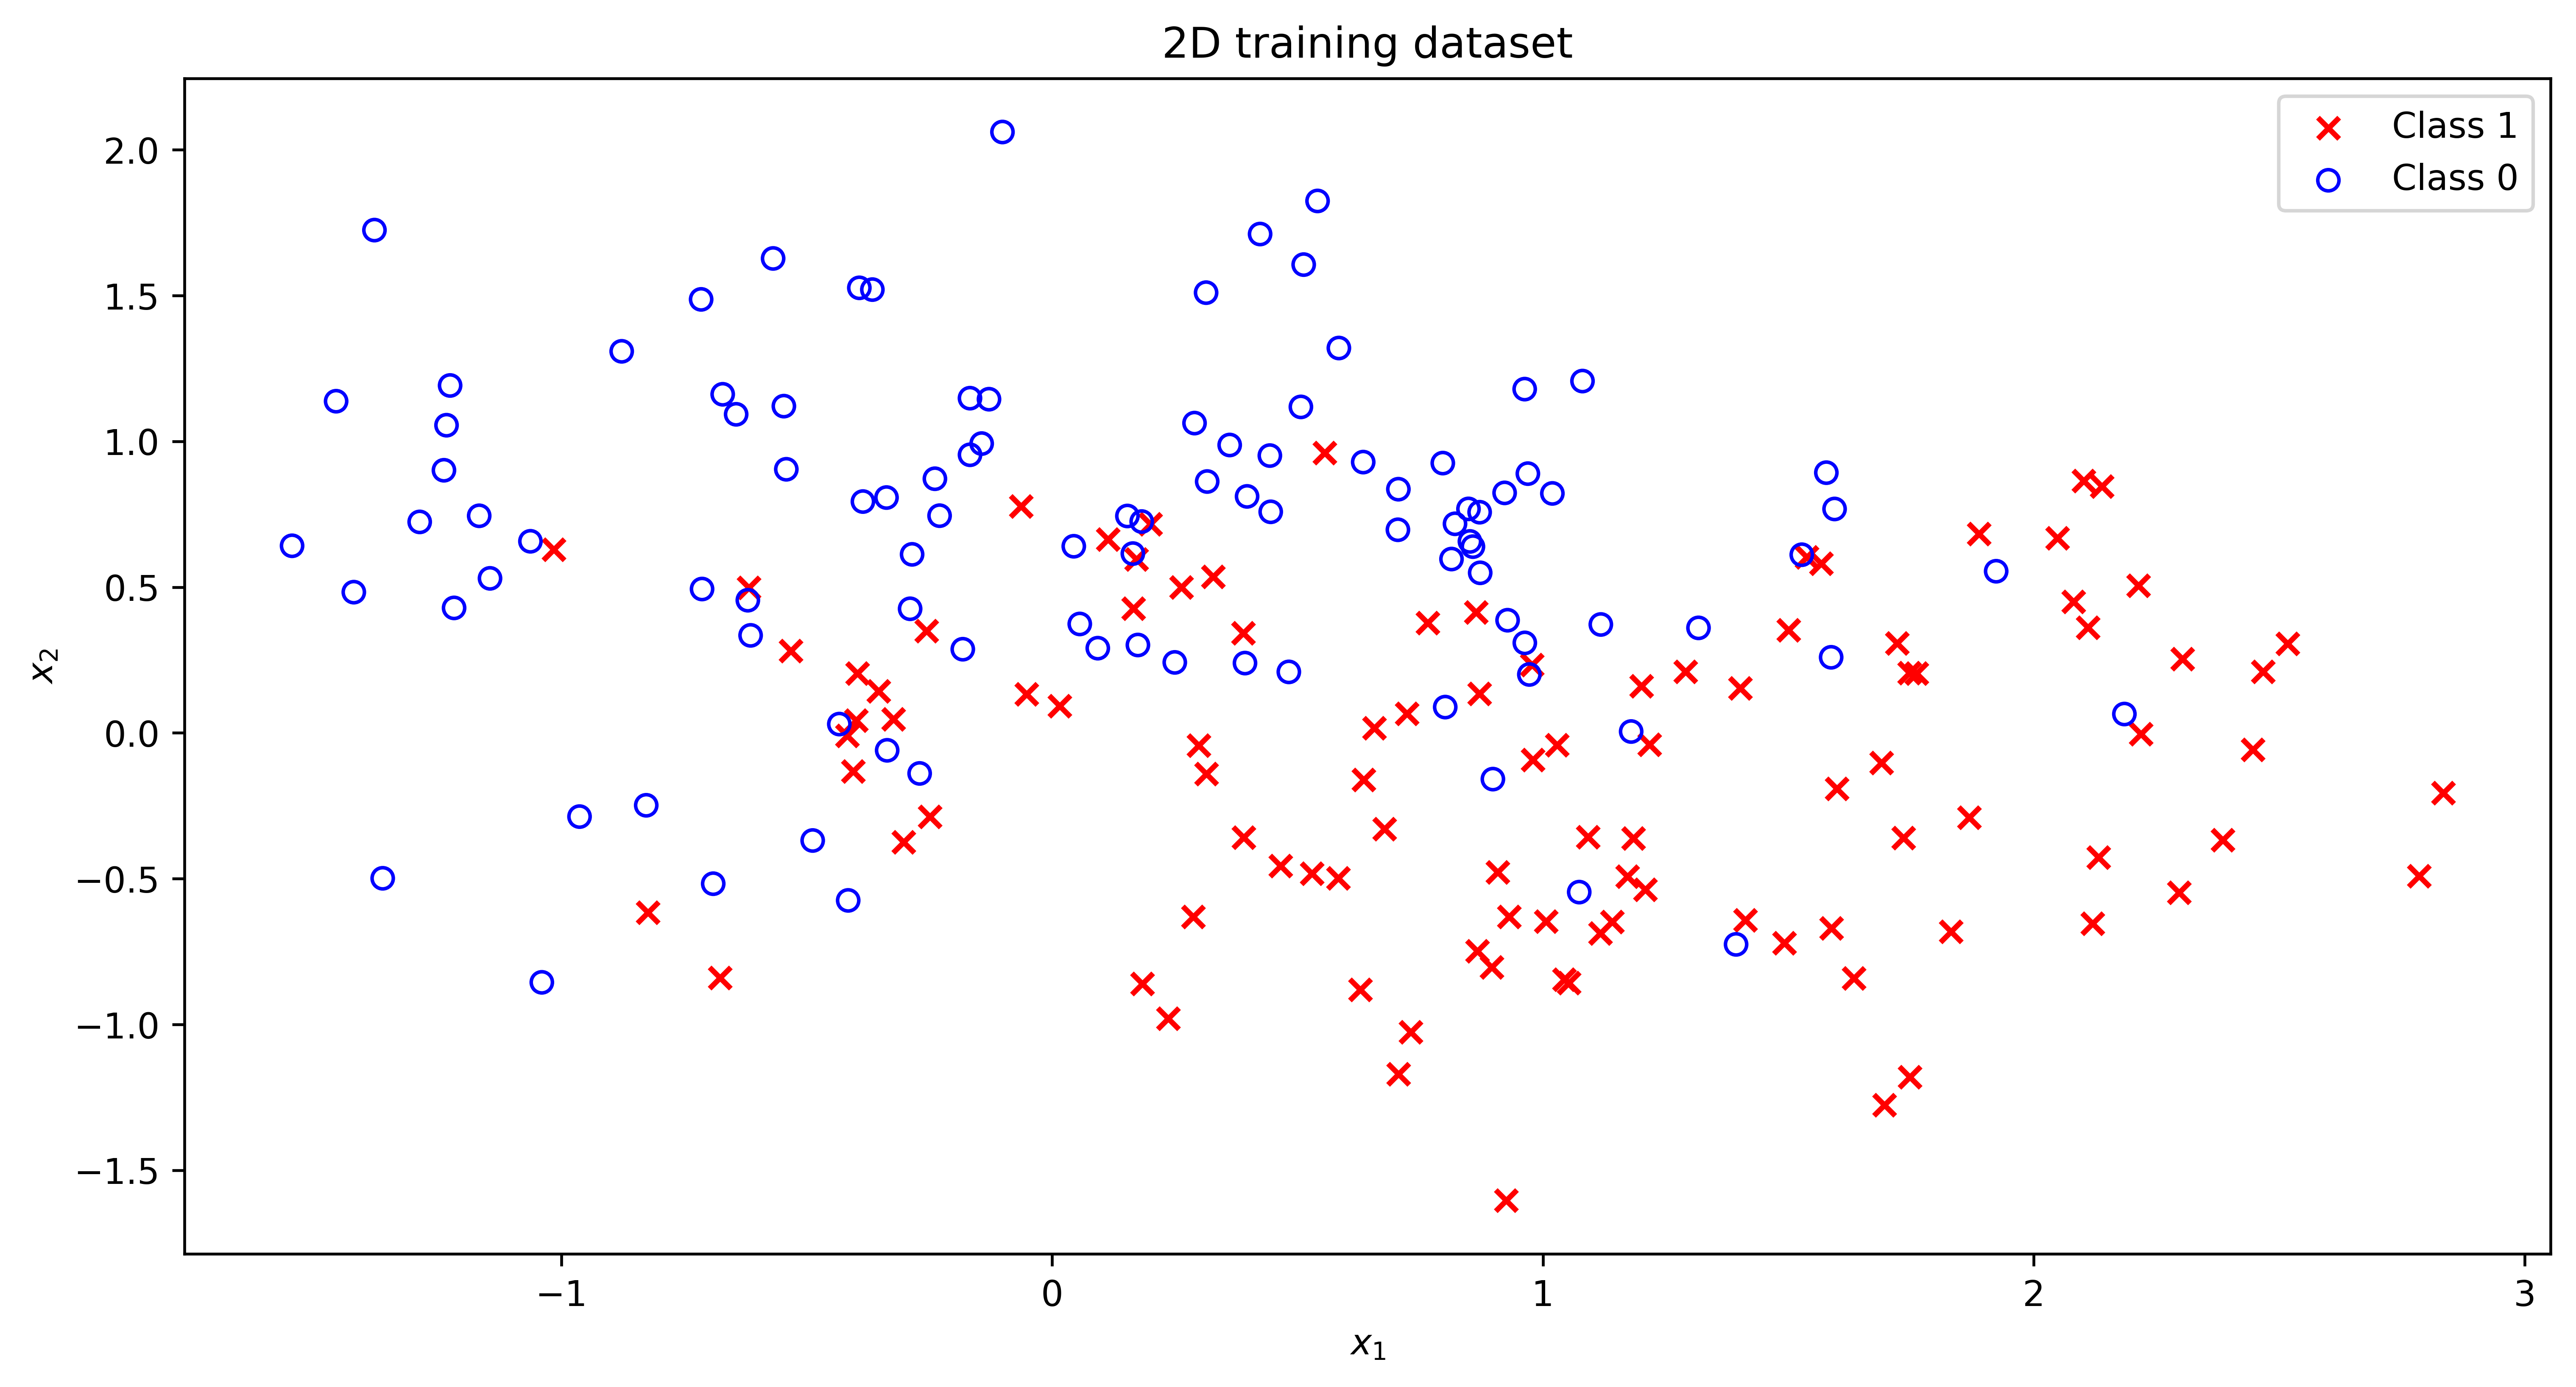

In [ ]:
X, y = make_moons(200, noise=0.5, random_state=1)
y = y.reshape(-1, 1)

plot_data_2D(X, y)
plt.title("2D training dataset")
plt.legend();

In [ ]:
res = minimize(
    nll_fn(X, y), [1, 1], bounds=((1e-3, None), (1e-3, None)), method="L-BFGS-B"
)

theta = res.x

print(
    f"Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}"
)

Optimized theta = [0.632, 8.491], negative log likelihood = 93.490


In [ ]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, y.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()["length_scale"]
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()["constant_value"])

print(
    f"Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}"
)

Optimized theta = [1.346, 3.360], negative log likelihood = 93.434


In [ ]:
grid_x, grid_y = np.mgrid[-4:4:200j, -4:4:200j]
grid = np.stack([grid_x, grid_y], axis=-1)

In [ ]:
pt_test = predict_py(grid.reshape(-1, 2), X, y, theta).reshape(*grid_x.shape)

plot_pt_2D(grid_x, grid_y, pt_test)
plot_db_2D(grid_x, grid_y, pt_test, decision_boundary=0.5)
plot_data_2D(X, y)
plt.title("Predicted class 1 probabilities")
plt.legend();

## Задача 1 (2 б.): Свертка
Докажите, что
$$
\int\Phi(\lambda a) N(a|\mu, \Sigma) = \Phi(\frac{\mu}{\sqrt{\lambda^{-2} + \sigma^2}})
$$


## Задача 2 (3 б.): Метод Ньютона
Метод Ньютона - итеративный алгоритм для поиска корней функции $f(x)$:

$x_{new} = x_{old} - J_f(x_{old})^{-1} f(x_{old})$

где $J$ - матрица Якоби. Выведите из этого определения формулу, которую мы использовали для поиска моды $\mathbb{P}(f|y)$:

$$
f^{new} = K(I+WK)^{-1} \cdot \Big[y-\sigma(f)+Wf\Big]
$$

---

This noptebook rely heavily on Martin Krasser's [course](https://github.com/krasserm) on Bayessian Machine Learning